# Multilayer Perceptron (MLP) for generating Onion-like News Headlines

Based on Andrej Karpathy's Youtube lecture [Building makemore Part 2: MLP](https://www.youtube.com/watch?v=TCH_1BHY58I) and Bengio et al's paper [A Neural Probabilistic Langue Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

import pdb, sys, warnings, os, json, torch, re, random
warnings.filterwarnings(action='ignore')

from IPython.display import display, HTML
from pathlib import Path

import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from torch.nn import functional as F
import torch.nn as nn

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
%matplotlib inline

seed = 2468975301

In [2]:
use_gpu = lambda gpu: 'cuda' if gpu else 'cpu'
device = use_gpu(False)

In [3]:
onion_df = pd.read_csv('../../data/cleaned_onion_headlines.csv')

texts = onion_df['text'].tolist()
vocab = ['#'] + sorted(list(set(' '.join(texts))))
stoi = {s:i for i,s in enumerate(vocab)}
itos = {i:s for i,s in enumerate(vocab)}
vocab_size = len(vocab)
vocab_size

28

## Functions

In [4]:
def build_dataset(texts, stoi, block_size=3):
  X,Y = [],[]

  for text in texts:
    context = [0] * block_size
    for ch in text:
      idx = stoi[ch]
      X.append(context)
      Y.append(idx)
      context = context[1:] + [idx]

  return torch.tensor(X, device=device), torch.tensor(Y, device=device)

In [5]:
def split_datasets(X, Y, train_pct=0.8, dev_pct=0.1, device='cpu'):
  X = X.to(device)
  Y = Y.to(device)
  r = np.random.RandomState(seed)
  idxs = np.arange(len(X))
  r.shuffle(idxs) 

  n1 = int(train_pct*len(idxs))
  n2 = int((train_pct+dev_pct)*len(idxs))  

  return X[idxs[:n1]],Y[idxs[:n1]],X[idxs[n1:n2]],Y[idxs[n1:n2]],X[idxs[n2:]],Y[idxs[n2:]]

## Build the Dataset

In [6]:
block_size = 3 # contenxt length: how many characters do we take to predict the next character
X,Y = [],[]

for text in texts[:1]:
  context = [0] * block_size
  print(text)
  for ch in text + '#':
    idx = stoi[ch]
    X.append(context)
    Y.append(idx)
    print(f"{''.join(itos[i] for i in context)} -----> {itos[idx]}")
    context = context[1:] + [idx]
# X,Y = torch.tensor(X, device=device),torch.tensor(Y, device=device)
X,Y = build_dataset(texts, stoi)
X.shape, Y.shape

entire facebook staff laughs as man tightens privacy settings
### -----> e
##e -----> n
#en -----> t
ent -----> i
nti -----> r
tir -----> e
ire ----->  
re  -----> f
e f -----> a
 fa -----> c
fac -----> e
ace -----> b
ceb -----> o
ebo -----> o
boo -----> k
ook ----->  
ok  -----> s
k s -----> t
 st -----> a
sta -----> f
taf -----> f
aff ----->  
ff  -----> l
f l -----> a
 la -----> u
lau -----> g
aug -----> h
ugh -----> s
ghs ----->  
hs  -----> a
s a -----> s
 as ----->  
as  -----> m
s m -----> a
 ma -----> n
man ----->  
an  -----> t
n t -----> i
 ti -----> g
tig -----> h
igh -----> t
ght -----> e
hte -----> n
ten -----> s
ens ----->  
ns  -----> p
s p -----> r
 pr -----> i
pri -----> v
riv -----> a
iva -----> c
vac -----> y
acy ----->  
cy  -----> s
y s -----> e
 se -----> t
set -----> t
ett -----> i
tti -----> n
tin -----> g
ing -----> s
ngs -----> #


(torch.Size([1128990, 3]), torch.Size([1128990]))

## Building the network

1. Let's build the table look-up `C` from the paper. In the paper, their vocab is 17K words with a 30-dim embedding. We have 28 characters, so we'll start with embedding them into 2 dimensions.
2. Lookup table is the *same* as matrix multiplication with one-hot enc.
3. Pytorch indexing with tensors with example C[X][13,2]



In [7]:
emb_size = 2
hidden_dim = 100
input_dim = block_size * emb_size

In [8]:
C = torch.randn((vocab_size, emb_size), device=device)
C.shape

torch.Size([28, 2])

In [9]:
emb = C[X]
emb.shape

torch.Size([1128990, 3, 2])

In [10]:
W1 = torch.randn(input_dim, hidden_dim)
b1 = torch.randn(hidden_dim)

Best way to transform tensors `view`

In [11]:
h = emb.view(-1, input_dim) @ W1 + b1
h.shape

torch.Size([1128990, 100])

In [12]:
W2 = torch.randn((hidden_dim, vocab_size), device=device)
b2 = torch.randn(vocab_size, device=device)

In [13]:
logits = h @ W2 + b2
logits.shape

torch.Size([1128990, 28])

In [14]:
loss = F.cross_entropy(logits, Y)
loss

tensor(47.9084)

In [15]:
g = torch.Generator(device=device).manual_seed(seed)
X = X.to(device=device)
Y = Y.to(device=device)
C = torch.randn(vocab_size, emb_size, generator=g, requires_grad=True, device=device)
W1 = torch.randn(input_dim, hidden_dim, generator=g, requires_grad=True, device=device)
b1 = torch.randn(hidden_dim, generator=g, requires_grad=True, device=device)
W2 = torch.randn(hidden_dim, vocab_size, generator=g, requires_grad=True, device=device)
b2 = torch.randn(vocab_size, generator=g, requires_grad=True, device=device)
params = [C, W1, b1, W2, b2]
n_params = sum([p.nelement() for p in params])
n_params

3584

In [16]:
batch_size = 32

In [17]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

1. So low loss because of single data point of 62 examples! 3584 params for 62 examples = overfitting single batch
2. minibatch SGD
3. Cuda
4. Learning rate determiner
5. Learning rate plateau

In [18]:
%%time

lri = []
lossi = []

for i in range(10000):
  # minibatch SGD
  idx = torch.randint(0, len(X), (batch_size, ))
  # forward pass
  emb = C[X[idx]]
  h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[idx])  

  # backward pass
  for p in params:
    p.grad = None
  loss.backward()  
  
  # lr = lrs[i]
  lr = 10**-0.8
  for p in params:
    p.data += -lr * p.grad
    
  # lri.append(lre[i])
  # lossi.append(loss.item())
    
print(loss.item())    

2.6932926177978516
CPU times: user 28.8 s, sys: 0 ns, total: 28.8 s
Wall time: 3.98 s


In [19]:
  emb = C[X]
  h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y)  
  print(f'{loss.item():0.4f}')

2.5450


In [20]:
# fig, ax = plt.subplots(1,1,figsize=(10, 8))
# ax.plot(lri, lossi)

## Dataset Splits

In [21]:
block_size = 3 # contenxt length: how many characters do we take to predict the next character
emb_size = 2
hidden_dim = 100
input_dim = block_size * emb_size
batch_size = 4096
log_lossi = []

X,Y = build_dataset(texts, stoi)

In [22]:
device = use_gpu(True)

In [23]:
X_train,Y_train,X_dev,Y_dev,X_test,Y_test = split_datasets(X,Y, device=device)

g = torch.Generator(device=device).manual_seed(seed)
C = torch.randn(vocab_size, emb_size, generator=g, requires_grad=True, device=device)
W1 = torch.randn(input_dim, hidden_dim, generator=g, requires_grad=True, device=device)
b1 = torch.randn(hidden_dim, generator=g, requires_grad=True, device=device)
W2 = torch.randn(hidden_dim, vocab_size, generator=g, requires_grad=True, device=device)
b2 = torch.randn(vocab_size, generator=g, requires_grad=True, device=device)
params = [C, W1, b1, W2, b2]

n_params = sum([p.nelement() for p in params])
print(f"Number of params: {n_params}")
print(f"Training set size: {X_train.nelement()}")
print(f"Dev set size: {X_dev.nelement()}")
print(f"Test set size: {X_dev.nelement()}")

Number of params: 3584
Training set size: 2709576
Dev set size: 338697
Test set size: 338697


In [24]:
%%time
for i in range(100000):
  idx = torch.randint(0, len(X_train), (batch_size, ))
  
  # forward pass
  emb = C[X_train[idx]]
  h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_train[idx])
  if i % 10000 == 0:
    print(f"Iteration: {i}, Loss: {loss.item():0.4f}")  

  # backward pass
  for p in params:
    p.grad = None
  loss.backward()  
  
  # lr = 10**-1.4
  lr = 10**-0.8 if i < 80000 else 10**-1.4
  for p in params:
    p.data += -lr * p.grad
    
  log_lossi.append(loss.log10().item())

# print(f'Training Loss: {loss.item():0.4f}')

Iteration: 0, Loss: 16.0216
Iteration: 10000, Loss: 2.4072
Iteration: 20000, Loss: 2.3160
Iteration: 30000, Loss: 2.2830
Iteration: 40000, Loss: 2.2443
Iteration: 50000, Loss: 2.2347
Iteration: 60000, Loss: 2.2133
Iteration: 70000, Loss: 2.1994
Iteration: 80000, Loss: 2.2148
Iteration: 90000, Loss: 2.1383
CPU times: user 2min 4s, sys: 1min 3s, total: 3min 7s
Wall time: 3min 4s


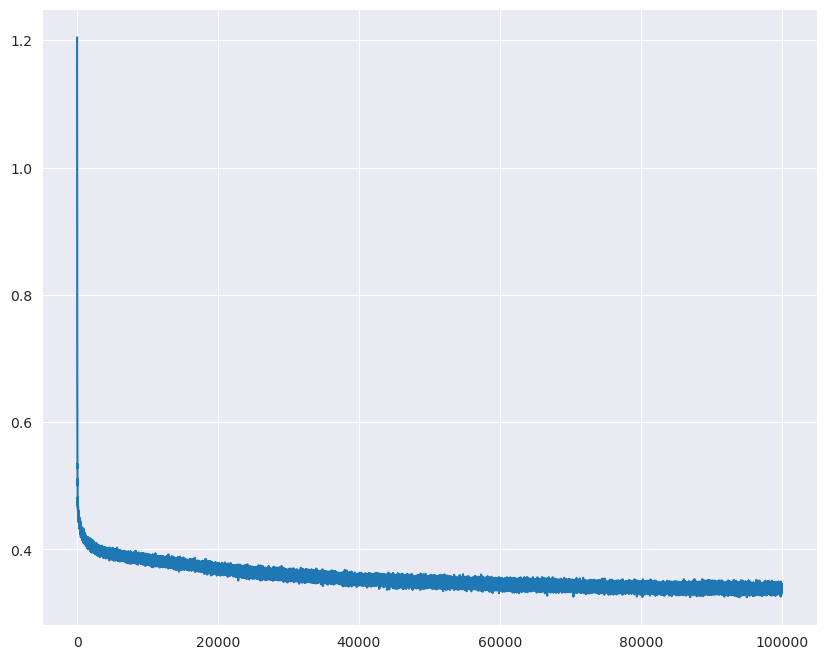

In [25]:
fig, ax = plt.subplots(1,1,figsize=(10, 8))
ax.plot(range(len(log_lossi)), log_lossi)

In [26]:
X_train,Y_train,X_dev,Y_dev = X_train.cpu(),Y_train.cpu(),X_dev.cpu(),Y_dev.cpu()
C,W1,b1,W2,b2 = C.cpu(),W1.cpu(),b1.cpu(),W2.cpu(),b2.cpu()

In [27]:
  emb = C[X_train]
  h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_train)  
  print(f'Training Loss: {loss.item():0.4f}')

Training Loss: 2.1802


In [28]:
  emb = C[X_dev]
  h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_dev)  
  print(f'Dev Loss: {loss.item():0.4f}')

Dev Loss: 2.1827


In [31]:
X_test,Y_test = X_test.cpu(),Y_test.cpu()

emb = C[X_test]
h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_test)  
print(f'Test Loss: {loss.item():0.4f}')

Test Loss: 2.1892


## Plot the embedding

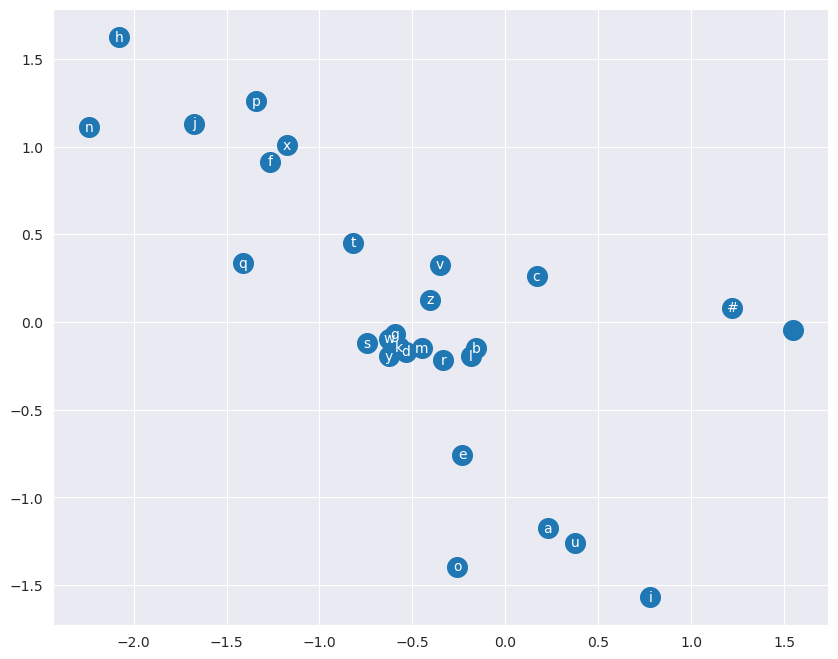

In [32]:
fig, ax = plt.subplots(1,1,figsize=(10, 8))
ax.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  ax.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
  ax.grid('minor')

## Sample from the model

In [36]:
g = torch.Generator().manual_seed(seed)
n_headlines = 20
for _ in range(n_headlines):  
  ai_onion = []
  context = [0] * block_size # initialize with all ###
  while True:
    emb = C[torch.tensor([context])] # (1, block_size)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    context = context[1:] + [idx]
    ai_onion.append(itos[idx])
    if idx == 0 or len(ai_onion) > np.random.randint(300, 600):
      break
  print(''.join(ai_onion[:-1]))

sth daish tonernt dewh any barllents uming follery und ramink amesfry anclagmy buwhting lod ind sater conge meck chinelsporeating hirt me thine on tada a detuckalbden ase secen for thitacers a gey than damesry vo ands lurill clion finys hop thica chyumicf bels frent try dute prels les to sones being he seek bicaita comerd iser unci
sochts new in unce pid abonnouse i lecorf to yayp in woyasinend asicaspir buss he mifcer gus bavewhce smagick dovined ate ithlielinsuyt ytuck natost texy in lurentixed swoth wor hae everstiendent af o pandmoter epatint ming of the gic abcelof the vapce salionsuy of plants doll sar dasts haght utcins of tely b
neled frel re keing seem grand ason dan elspowo dikonade he in doa orthould dilples as the sue womn fuckenconge hos at to prock bise keged plie nathe rats medp in inny prar ucoveres thw gooth two swumes fust ting fardeallepound mift scides meadcheresiesers facory orren arpres con of pupploples may wtor titting confon day sayt riter gupfing ic
lems oftie